### Calculate spatial maps, seasonal means

In [1]:
import xarray as xr
import numpy as np
import dask
import matplotlib.pyplot as plt
from utils import geo
import regionmask
from dask.diagnostics import ProgressBar

In [2]:
dask.config.set(**{'array.slicing.split_large_chunks': False})

In [3]:
rootdir = '/local/data/globcolour/from_cmems/OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009_082/SouthernOcean_30Sto65S/daily/in_months/'
filename = '*.nc'
def preprocess(ds):
    return ds.where(ds['time.month']==ds['time.month'][0],drop=True).chunk({'time':1})
ds = xr.open_mfdataset(rootdir+filename,preprocess=preprocess)
ds = ds.sel(lat=slice(-30,-70))
# Get area
ds,xgrid = geo.get_xgcm_horizontal(ds,periodic='X')
ds['area'] = ds['dxC']*ds['dyC']

In [4]:
# Apply a landmask
mask = regionmask.defined_regions.natural_earth.land_110.mask(ds['lon'], ds['lat'])
mask = mask.where(np.isfinite(mask),1)
mask = mask.where(mask==1,np.nan)
# Set unseen ocean to 0 and land to nan
ds['CHL'] = ds['CHL'].fillna(0)*mask

In [18]:
ds = ds.chunk({'time':8649,'lon':108,'lat':21})

In [19]:
# Calculate DJF climatology 
djf_clim = ds['CHL'].sel(time=slice('1997','2020')).groupby('time.season').mean('time').sel(season='DJF')

In [20]:
with ProgressBar():
    djf_clim.to_netcdf('../../data/globcolour_cmems_daily_CHL_DJFclim.nc')

[                                        ] | 0% Completed |  3min  8.0s


KeyboardInterrupt: 

In [34]:
ds2021 = ds.sel(time=slice('2020-12-01','2021-02-28')).mean('time')

In [35]:
anom = ds2021-clim

/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


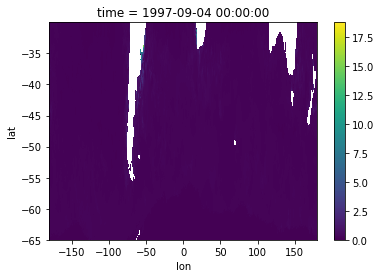

In [9]:
ds['CHL'].coarsen({'lon':4,'lat':4}).mean().isel(time=0).plot()